# User Latent Dirichlet Allocation

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sys.path.append(os.path.abspath('../../vae_playground'))
sys.path.append(os.path.abspath('..'))

In [3]:
%load_ext autoreload
%autoreload 2

from lib.models import InductiveLDA as InductiveLDA

from sklearn.cluster import KMeans

import vae_playground.datasets as datasets

Import Data

In [4]:
DATASET_NAME = 'goi4_dp_small'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [5]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 631815 consumption profiles from 365 dates and 1731 users


In [6]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = torch.tensor(data, dtype=torch.float32).reshape(-1, 24)
    #circle shift the last dimension of X
    X = torch.cat([X[:,6:], X[:,:6]], dim=-1).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
else:
    X = torch.tensor(data, dtype=torch.float32).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
dates, users = np.reshape(dates, (num_users, num_days)), np.reshape(users, (num_users, num_days))

In [7]:
# Remove users with all-zero consumption profiles
nonzero_user_mask = torch.sum(torch.all(X == 0, dim=2), dim=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = torch.sum(torch.any(X < 0, dim=2), dim=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


In [8]:
X = X[user_mask]
dates, users = dates[user_mask], users[user_mask]
user_ids = user_ids[user_mask]

In [9]:
USER_SUBSAMPLE_RATE = 1
DAY_SUBSAMPLE_RATE = 1
X = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
num_users, num_days, num_features = X.shape
X = X.flatten(end_dim=1)
print(f"Number of (subsampled/filtered) users: {num_users}")
print(f"Number of (subsampled) days: {num_days}")
print(f"Number of (aggregated) features: {num_features}")

Number of (subsampled/filtered) users: 1709
Number of (subsampled) days: 365
Number of (aggregated) features: 24


In [10]:
nonzero_mean, nonzero_std = datasets.zero_preserved_log_stats(X)
X_norm = datasets.zero_preserved_log_normalize(X, nonzero_mean, nonzero_std).reshape(num_users, num_days, num_features)
dataset = datasets.UserDayDataset(X_norm)
X_flt = dataset.flatten_inputs
user_idx, day_idx = dataset.user_day_list[:,0], dataset.user_day_list[:,1]

In [11]:
df_plt = pd.DataFrame(torch.cat((X_flt, user_idx.unsqueeze(1), day_idx.unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['user'] + ['day']

In [12]:
if num_users <= 100 and num_features == 2:
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='user', palette="Set1", alpha=.5)
    # move the legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='user', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [13]:
n_bins = 100
kmeans = KMeans(n_clusters=n_bins, random_state=RANDOM_SEED, n_init='auto').fit(X_flt)

In [14]:
labels = kmeans.labels_
labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1
X_words = torch.tensor(labels_onehot).reshape(num_users, num_days, -1)

In [15]:
DOC_TYPE = "day"       # "day" or "user"

if DOC_TYPE == "day":
    X_document, num_words = X_words.sum(dim=0), num_users
elif DOC_TYPE == "user":
    X_document, num_words = X_words.sum(dim=1), num_days
else:
    raise ValueError(f"Invalid DOC_TYPE: {DOC_TYPE}")

num_docs, dict_size = X_document.shape[0], n_bins

In [16]:
if dict_size <= 50 and num_features == 2:
    df_plt = pd.DataFrame(torch.cat((X_flt,torch.tensor(labels).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['word']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='word', palette="Set2", alpha=.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='word_id', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [17]:
X_labels = torch.tensor(labels).reshape(num_users, num_days)
if DOC_TYPE == "day": X_labels = X_labels.T

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X): self.X = X
    def __len__(self): return len(self.X)
    def __getitem__(self, index): return self.X[index]

In [19]:
dataset = Dataset(X_document.to(torch.float32))

In [20]:
# Set training parameters.
num_topics = 10
prodlda = False
conv = False
num_layers = 2 # num hidden layers in the NN block. There are at least 1+num_heads hidden layers in the encoder and decoder. num_layers comes on top of those. Total number of hidden layers is 1+num_layers+num_heads.
num_neurons = 200
dropout = True
dropout_rate = 0.5
batch_normalization = True
prior_params = {'alpha': 1.0}

In [21]:
model = InductiveLDA(input_dim=n_bins,
                    num_topics=num_topics,
                    prior_params=prior_params,
                    conv=conv,
                    prodlda=prodlda,
                    num_hidden_layers=num_layers,
                    num_neurons=num_neurons,
                    dropout=dropout,
                    dropout_rate=dropout_rate,
                    batch_normalization=batch_normalization,
                    )

In [22]:
lr = 1e-3
batch_size = 32
num_epochs = 1000
beta = 1.0
learn_prior = True

In [23]:
# Train the model using default partitioning choice 
model.fit(lr=lr,
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True),
            epochs = num_epochs,
            beta = beta,
            mc_samples = 1,
            learn_prior = learn_prior,
            tensorboard = False,
            )

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 1/1000 [00:00<11:48,  1.41it/s]/home/kbolat/miniconda3/envs/torchenv/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
                                                       
Epoch:   1%|          | 10/1000 [00:01<02:11,  7.54it/s]  

Iteration: 100 -- ELBO=-7.93e+03 / RLL=-7.91e+03 / KL=2.18e+01


                                                        
Epoch:   2%|▏         | 20/1000 [00:02<01:17, 12.56it/s]  

Iteration: 200 -- ELBO=-7.83e+03 / RLL=-7.81e+03 / KL=2.17e+01


                                                        
Epoch:   3%|▎         | 28/1000 [00:03<01:04, 14.97it/s]  

Iteration: 300 -- ELBO=-7.74e+03 / RLL=-7.72e+03 / KL=2.12e+01


                                                        
Epoch:   4%|▎         | 36/1000 [00:03<01:02, 15.50it/s]  

Iteration: 400 -- ELBO=-7.69e+03 / RLL=-7.67e+03 / KL=2.09e+01


                                                        
Epoch:   4%|▍         | 44/1000 [00:04<01:00, 15.90it/s]  

Iteration: 500 -- ELBO=-7.63e+03 / RLL=-7.61e+03 / KL=2.03e+01


                                                        
Epoch:   5%|▌         | 54/1000 [00:04<00:58, 16.23it/s]  

Iteration: 600 -- ELBO=-7.62e+03 / RLL=-7.60e+03 / KL=1.94e+01


                                                        
Epoch:   6%|▌         | 62/1000 [00:05<00:58, 16.02it/s]  

Iteration: 700 -- ELBO=-7.53e+03 / RLL=-7.51e+03 / KL=1.88e+01


                                                        
Epoch:   7%|▋         | 70/1000 [00:05<00:57, 16.11it/s]  

Iteration: 800 -- ELBO=-7.47e+03 / RLL=-7.45e+03 / KL=1.82e+01


                                                        
Epoch:   8%|▊         | 78/1000 [00:06<00:57, 16.14it/s]  

Iteration: 900 -- ELBO=-7.48e+03 / RLL=-7.46e+03 / KL=1.77e+01


                                                        
Epoch:   9%|▊         | 86/1000 [00:06<00:56, 16.21it/s]  

Iteration: 1000 -- ELBO=-7.39e+03 / RLL=-7.38e+03 / KL=1.74e+01


                                                        
Epoch:   9%|▉         | 94/1000 [00:07<00:57, 15.89it/s]  

Iteration: 1100 -- ELBO=-7.42e+03 / RLL=-7.41e+03 / KL=1.71e+01


                                                         
Epoch:  10%|█         | 102/1000 [00:07<01:00, 14.89it/s] 

Iteration: 1200 -- ELBO=-7.39e+03 / RLL=-7.37e+03 / KL=1.68e+01


                                                         
Epoch:  11%|█         | 112/1000 [00:08<00:59, 14.95it/s] 

Iteration: 1300 -- ELBO=-7.36e+03 / RLL=-7.35e+03 / KL=1.68e+01


                                                         
Epoch:  12%|█▏        | 120/1000 [00:08<00:56, 15.62it/s] 

Iteration: 1400 -- ELBO=-7.34e+03 / RLL=-7.33e+03 / KL=1.64e+01


                                                         
Epoch:  13%|█▎        | 128/1000 [00:09<00:53, 16.21it/s] 

Iteration: 1500 -- ELBO=-7.38e+03 / RLL=-7.37e+03 / KL=1.65e+01


                                                         
Epoch:  14%|█▎        | 136/1000 [00:09<00:59, 14.63it/s] 

Iteration: 1600 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=1.64e+01


                                                         
Epoch:  14%|█▍        | 144/1000 [00:10<00:55, 15.51it/s] 

Iteration: 1700 -- ELBO=-7.31e+03 / RLL=-7.29e+03 / KL=1.65e+01


                                                         
Epoch:  15%|█▌        | 154/1000 [00:11<00:53, 15.91it/s] 

Iteration: 1800 -- ELBO=-7.39e+03 / RLL=-7.37e+03 / KL=1.65e+01


                                                         
Epoch:  16%|█▌        | 162/1000 [00:11<00:51, 16.21it/s] 

Iteration: 1900 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=1.62e+01


                                                         
Epoch:  17%|█▋        | 170/1000 [00:12<00:51, 16.13it/s] 

Iteration: 2000 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.60e+01


                                                         
Epoch:  18%|█▊        | 178/1000 [00:12<00:50, 16.31it/s] 

Iteration: 2100 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.59e+01


                                                         
Epoch:  19%|█▊        | 186/1000 [00:13<00:52, 15.36it/s] 

Iteration: 2200 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.61e+01


                                                         
Epoch:  19%|█▉        | 194/1000 [00:13<00:53, 14.96it/s] 

Iteration: 2300 -- ELBO=-7.32e+03 / RLL=-7.31e+03 / KL=1.59e+01


                                                         
Epoch:  20%|██        | 202/1000 [00:14<00:53, 14.93it/s] 

Iteration: 2400 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.52e+01


                                                         
Epoch:  21%|██        | 212/1000 [00:14<00:49, 15.83it/s] 

Iteration: 2500 -- ELBO=-7.26e+03 / RLL=-7.25e+03 / KL=1.56e+01


                                                         
Epoch:  22%|██▏       | 220/1000 [00:15<00:47, 16.26it/s] 

Iteration: 2600 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.55e+01


                                                         
Epoch:  23%|██▎       | 228/1000 [00:15<00:48, 15.86it/s] 


Iteration: 2700 -- ELBO=-7.35e+03 / RLL=-7.33e+03 / KL=1.55e+01


                                                         ]
Epoch:  24%|██▎       | 236/1000 [00:16<00:50, 15.11it/s] 

Iteration: 2800 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.55e+01


                                                         
Epoch:  24%|██▍       | 244/1000 [00:16<00:51, 14.72it/s] 

Iteration: 2900 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.55e+01


                                                         
Epoch:  25%|██▌       | 252/1000 [00:17<00:49, 15.17it/s] 

Iteration: 3000 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.56e+01


                                                         
Epoch:  26%|██▌       | 262/1000 [00:18<00:49, 14.99it/s] 

Iteration: 3100 -- ELBO=-7.31e+03 / RLL=-7.30e+03 / KL=1.57e+01


                                                         
Epoch:  27%|██▋       | 270/1000 [00:18<00:49, 14.86it/s] 

Iteration: 3200 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.53e+01


                                                         
Epoch:  28%|██▊       | 278/1000 [00:19<00:48, 15.00it/s] 

Iteration: 3300 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.54e+01


                                                         
Epoch:  29%|██▊       | 286/1000 [00:19<00:48, 14.78it/s] 

Iteration: 3400 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.50e+01


                                                         
Epoch:  29%|██▉       | 294/1000 [00:20<00:54, 12.84it/s] 

Iteration: 3500 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.51e+01


                                                         
Epoch:  30%|███       | 304/1000 [00:20<00:46, 15.13it/s] 

Iteration: 3600 -- ELBO=-7.17e+03 / RLL=-7.16e+03 / KL=1.50e+01


                                                         
Epoch:  31%|███       | 312/1000 [00:21<00:42, 16.07it/s] 

Iteration: 3700 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.53e+01


                                                         
Epoch:  32%|███▏      | 320/1000 [00:21<00:44, 15.34it/s] 

Iteration: 3800 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.50e+01


                                                         
Epoch:  33%|███▎      | 328/1000 [00:22<00:44, 15.20it/s] 


Iteration: 3900 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.53e+01


                                                         ]
Epoch:  34%|███▎      | 336/1000 [00:23<00:44, 15.01it/s] 

Iteration: 4000 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.50e+01


                                                         
Epoch:  34%|███▍      | 344/1000 [00:23<00:42, 15.53it/s] 

Iteration: 4100 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.52e+01


                                                         
Epoch:  35%|███▌      | 352/1000 [00:24<00:42, 15.08it/s] 

Iteration: 4200 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.50e+01


                                                         
Epoch:  36%|███▌      | 362/1000 [00:24<00:41, 15.36it/s] 

Iteration: 4300 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.50e+01


                                                         
Epoch:  37%|███▋      | 370/1000 [00:25<00:41, 15.15it/s] 

Iteration: 4400 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.51e+01


                                                         
Epoch:  38%|███▊      | 378/1000 [00:25<00:40, 15.20it/s] 

Iteration: 4500 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.51e+01


                                                         
Epoch:  39%|███▊      | 386/1000 [00:26<00:38, 16.00it/s] 

Iteration: 4600 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.47e+01


                                                         
Epoch:  39%|███▉      | 394/1000 [00:26<00:39, 15.19it/s] 

Iteration: 4700 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.51e+01


                                                         
Iteration in Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration: 4800 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.49e+01


                                                         
Epoch:  41%|████      | 412/1000 [00:27<00:39, 14.97it/s] 

Iteration: 4900 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.47e+01


                                                         
Epoch:  42%|████▏     | 420/1000 [00:28<00:38, 14.96it/s] 

Iteration: 5000 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.48e+01


                                                         
Epoch:  43%|████▎     | 428/1000 [00:29<00:38, 15.02it/s] 

Iteration: 5100 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.55e+01


                                                         
Epoch:  44%|████▎     | 436/1000 [00:29<00:37, 14.85it/s] 

Iteration: 5200 -- ELBO=-7.21e+03 / RLL=-7.19e+03 / KL=1.49e+01


                                                         
Epoch:  44%|████▍     | 444/1000 [00:30<00:37, 14.89it/s] 

Iteration: 5300 -- ELBO=-7.18e+03 / RLL=-7.17e+03 / KL=1.48e+01


                                                         
Epoch:  45%|████▌     | 454/1000 [00:30<00:36, 15.12it/s] 

Iteration: 5400 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.54e+01


                                                         
Epoch:  46%|████▌     | 462/1000 [00:31<00:35, 15.17it/s] 

Iteration: 5500 -- ELBO=-7.32e+03 / RLL=-7.30e+03 / KL=1.53e+01


                                                         
Epoch:  47%|████▋     | 470/1000 [00:31<00:35, 14.99it/s] 

Iteration: 5600 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.47e+01


                                                         
Iteration in Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration: 5700 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.43e+01


                                                         
Epoch:  49%|████▊     | 486/1000 [00:32<00:34, 14.87it/s] 

Iteration: 5800 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.48e+01


                                                         
Epoch:  49%|████▉     | 494/1000 [00:33<00:36, 13.84it/s] 

Iteration: 5900 -- ELBO=-7.21e+03 / RLL=-7.19e+03 / KL=1.47e+01


                                                         
Epoch:  50%|█████     | 502/1000 [00:34<00:34, 14.59it/s] 

Iteration: 6000 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.45e+01


                                                         
Epoch:  51%|█████     | 510/1000 [00:34<00:41, 11.76it/s] 

Iteration: 6100 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.48e+01


                                                         
Epoch:  52%|█████▏    | 520/1000 [00:35<00:36, 13.25it/s] 

Iteration: 6200 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.47e+01


                                                         
Epoch:  53%|█████▎    | 528/1000 [00:36<00:32, 14.58it/s] 

Iteration: 6300 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.56e+01


                                                         
Epoch:  54%|█████▎    | 536/1000 [00:36<00:31, 14.61it/s] 

Iteration: 6400 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.47e+01


                                                         
Epoch:  54%|█████▍    | 544/1000 [00:37<00:29, 15.30it/s] 

Iteration: 6500 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.51e+01


                                                         
Epoch:  55%|█████▌    | 554/1000 [00:37<00:27, 16.12it/s] 

Iteration: 6600 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=1.50e+01


                                                         
Epoch:  56%|█████▌    | 562/1000 [00:38<00:27, 16.07it/s] 

Iteration: 6700 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.47e+01


                                                         
Epoch:  57%|█████▋    | 570/1000 [00:38<00:26, 16.19it/s] 

Iteration: 6800 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.49e+01


                                                         
Epoch:  58%|█████▊    | 578/1000 [00:39<00:26, 16.19it/s] 

Iteration: 6900 -- ELBO=-7.38e+03 / RLL=-7.37e+03 / KL=1.48e+01


                                                         
Epoch:  59%|█████▊    | 586/1000 [00:39<00:26, 15.82it/s] 

Iteration: 7000 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.51e+01


                                                         
Epoch:  59%|█████▉    | 594/1000 [00:40<00:30, 13.29it/s] 

Iteration: 7100 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.45e+01


                                                         
Epoch:  60%|██████    | 604/1000 [00:40<00:26, 15.14it/s] 

Iteration: 7200 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=1.49e+01


                                                         
Epoch:  61%|██████    | 612/1000 [00:41<00:26, 14.81it/s] 

Iteration: 7300 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.46e+01


                                                         
Epoch:  62%|██████▏   | 620/1000 [00:42<00:25, 15.00it/s] 

Iteration: 7400 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.48e+01


                                                         
Epoch:  63%|██████▎   | 628/1000 [00:42<00:23, 15.59it/s] 

Iteration: 7500 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.49e+01


                                                         
Epoch:  64%|██████▎   | 636/1000 [00:43<00:22, 15.87it/s] 

Iteration: 7600 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.49e+01


                                                         
Epoch:  64%|██████▍   | 644/1000 [00:43<00:22, 15.71it/s] 

Iteration: 7700 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.47e+01


                                                         
Epoch:  65%|██████▌   | 654/1000 [00:44<00:21, 15.77it/s] 

Iteration: 7800 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.55e+01


                                                         
Epoch:  66%|██████▌   | 662/1000 [00:44<00:21, 15.38it/s] 

Iteration: 7900 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.49e+01


                                                         
Epoch:  67%|██████▋   | 670/1000 [00:45<00:20, 15.87it/s] 

Iteration: 8000 -- ELBO=-7.17e+03 / RLL=-7.15e+03 / KL=1.44e+01


                                                         
Epoch:  68%|██████▊   | 678/1000 [00:45<00:19, 16.13it/s] 

Iteration: 8100 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.50e+01


                                                         
Epoch:  69%|██████▊   | 686/1000 [00:46<00:20, 15.29it/s] 

Iteration: 8200 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.46e+01


                                                         
Epoch:  69%|██████▉   | 694/1000 [00:46<00:19, 15.65it/s] 

Iteration: 8300 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.45e+01


                                                         
Epoch:  70%|███████   | 704/1000 [00:47<00:18, 16.09it/s] 

Iteration: 8400 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.46e+01


                                                         
Epoch:  71%|███████   | 712/1000 [00:47<00:18, 15.47it/s] 

Iteration: 8500 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.46e+01


                                                         
Epoch:  72%|███████▏  | 720/1000 [00:48<00:17, 16.06it/s] 

Iteration: 8600 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.46e+01


                                                         
Epoch:  73%|███████▎  | 728/1000 [00:48<00:17, 15.92it/s] 

Iteration: 8700 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.44e+01


                                                         
Epoch:  74%|███████▎  | 736/1000 [00:49<00:16, 15.99it/s] 

Iteration: 8800 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.47e+01


                                                         
Epoch:  74%|███████▍  | 744/1000 [00:49<00:15, 16.14it/s] 

Iteration: 8900 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.43e+01


                                                         
Epoch:  75%|███████▌  | 754/1000 [00:50<00:15, 16.30it/s] 

Iteration: 9000 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.46e+01


                                                         
Epoch:  76%|███████▌  | 762/1000 [00:51<00:14, 16.31it/s] 

Iteration: 9100 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.45e+01


                                                         
Epoch:  77%|███████▋  | 770/1000 [00:51<00:15, 14.86it/s] 

Iteration: 9200 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.43e+01


                                                         
Epoch:  78%|███████▊  | 778/1000 [00:52<00:14, 15.44it/s] 

Iteration: 9300 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.47e+01


                                                         
Epoch:  79%|███████▊  | 786/1000 [00:52<00:14, 15.11it/s] 

Iteration: 9400 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.44e+01


                                                         
Epoch:  79%|███████▉  | 794/1000 [00:53<00:13, 15.16it/s] 

Iteration: 9500 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.44e+01


                                                         
Epoch:  80%|████████  | 804/1000 [00:53<00:12, 16.16it/s] 

Iteration: 9600 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.46e+01


                                                         
Epoch:  81%|████████  | 812/1000 [00:54<00:11, 15.80it/s] 

Iteration: 9700 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.43e+01


                                                         
Epoch:  82%|████████▏ | 820/1000 [00:54<00:11, 15.94it/s] 

Iteration: 9800 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.40e+01


                                                         
Epoch:  83%|████████▎ | 828/1000 [00:55<00:10, 15.77it/s] 

Iteration: 9900 -- ELBO=-7.09e+03 / RLL=-7.07e+03 / KL=1.41e+01


                                                         
Epoch:  84%|████████▎ | 836/1000 [00:55<00:10, 15.75it/s] 

Iteration: 10000 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.42e+01


                                                         
Epoch:  84%|████████▍ | 844/1000 [00:56<00:09, 15.85it/s] 

Iteration: 10100 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.40e+01


                                                         
Iteration in Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration: 10200 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.36e+01


                                                         
Epoch:  86%|████████▌ | 862/1000 [00:57<00:08, 15.40it/s] 

Iteration: 10300 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.44e+01


                                                         
Epoch:  87%|████████▋ | 870/1000 [00:58<00:08, 15.29it/s] 

Iteration: 10400 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.44e+01


                                                         
Epoch:  88%|████████▊ | 878/1000 [00:58<00:07, 15.26it/s] 

Iteration: 10500 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.41e+01


                                                         
Epoch:  89%|████████▊ | 886/1000 [00:59<00:07, 15.91it/s] 

Iteration: 10600 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.46e+01


                                                         
Epoch:  89%|████████▉ | 894/1000 [00:59<00:06, 15.54it/s] 

Iteration: 10700 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.38e+01


                                                         
Epoch:  90%|█████████ | 904/1000 [01:00<00:05, 16.27it/s] 

Iteration: 10800 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.36e+01


                                                         
Epoch:  91%|█████████ | 912/1000 [01:00<00:05, 15.73it/s] 

Iteration: 10900 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.34e+01


                                                         
Epoch:  92%|█████████▏| 920/1000 [01:01<00:05, 15.43it/s] 

Iteration: 11000 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.38e+01


                                                         
Epoch:  93%|█████████▎| 926/1000 [01:01<00:04, 15.74it/s] 

Iteration: 11100 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.43e+01


                                                         
Epoch:  94%|█████████▎| 936/1000 [01:02<00:04, 14.37it/s] 

Iteration: 11200 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.37e+01


                                                         
Epoch:  94%|█████████▍| 944/1000 [01:02<00:03, 14.69it/s] 

Iteration: 11300 -- ELBO=-7.19e+03 / RLL=-7.17e+03 / KL=1.37e+01


                                                         
Epoch:  95%|█████████▌| 954/1000 [01:03<00:03, 15.11it/s] 


Iteration: 11400 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.41e+01


                                                         ]
Epoch:  96%|█████████▌| 962/1000 [01:04<00:02, 13.60it/s] 

Iteration: 11500 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.38e+01


                                                         
Epoch:  97%|█████████▋| 970/1000 [01:04<00:02, 12.90it/s] 

Iteration: 11600 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.38e+01


                                                         
Epoch:  98%|█████████▊| 978/1000 [01:05<00:01, 11.89it/s] 

Iteration: 11700 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.30e+01


                                                         
Epoch:  99%|█████████▊| 986/1000 [01:06<00:00, 14.41it/s] 

Iteration: 11800 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.38e+01


                                                         
Epoch:  99%|█████████▉| 994/1000 [01:06<00:00, 15.10it/s] 

Iteration: 11900 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.32e+01


                                                          
Iteration in Epoch: 100%|██████████| 12/12 [00:00<00:00, 173.31it/s]


Iteration: 12000 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.38e+01


In [24]:
model.prior_params["alpha"].exp()

tensor([0.4623, 0.0013, 1.2322, 0.0708, 0.1553, 0.7747, 0.0013, 0.2901, 0.0018,
        0.0856], grad_fn=<ExpBackward0>)

In [25]:
model.eval()

InductiveLDA(
  (encoder): DirichletNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=100, out_features=200, bias=True)
            (1): ELU(alpha=1.0)
            (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.5, inplace=False)
          )
          (middle_layers): ModuleList(
            (0-1): 2 x Sequential(
              (0): Linear(in_features=200, out_features=200, bias=True)
              (1): ELU(alpha=1.0)
              (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): Dropout(p=0.5, inplace=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=200, out_features=200, bias=True)
            (1): ELU(alpha=1.0)
            (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, t

In [26]:
_, theta_dict = model(X_document.to(torch.float32))
gamma_document = theta_dict['params']['alpha'].detach().T
gamma_document_mean = gamma_document / gamma_document.sum(dim=0, keepdim=True)

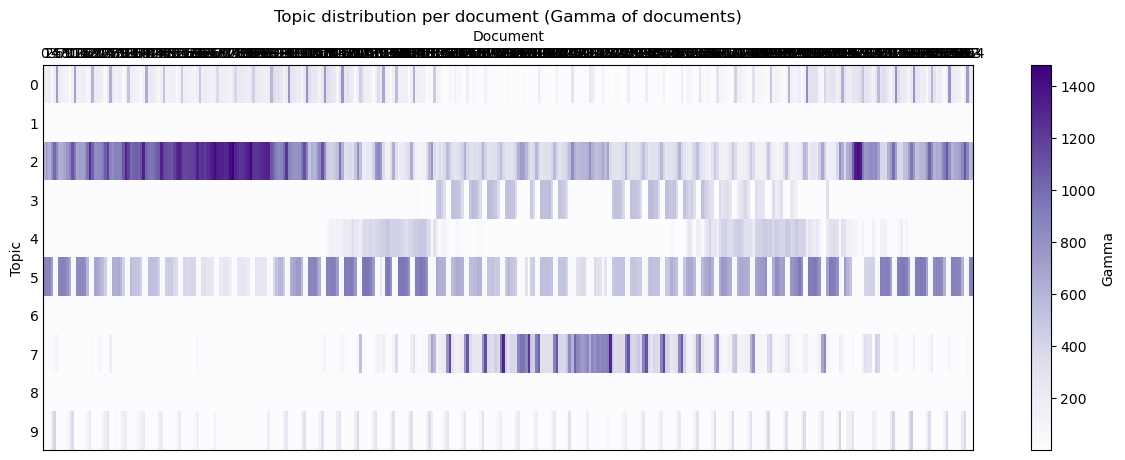

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Gamma')
plt.show()

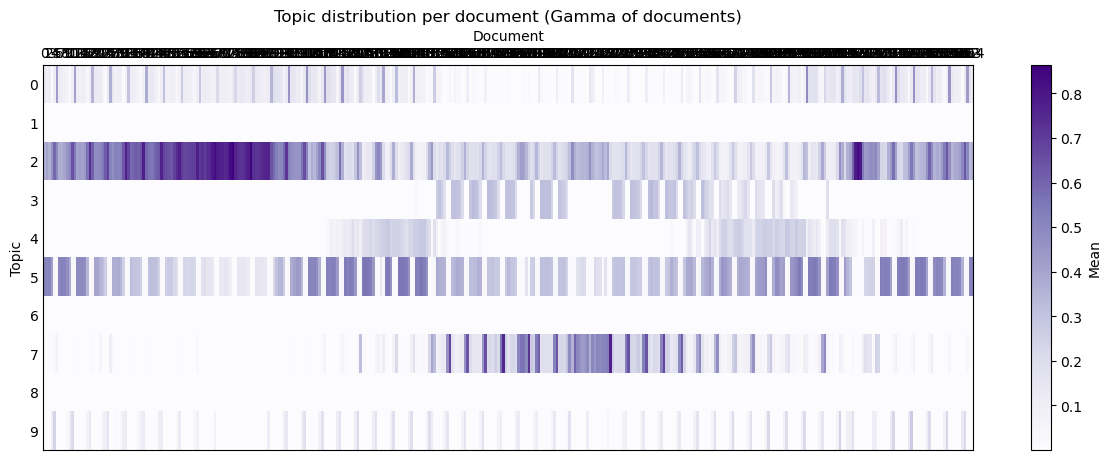

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document_mean, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Mean')
plt.show()

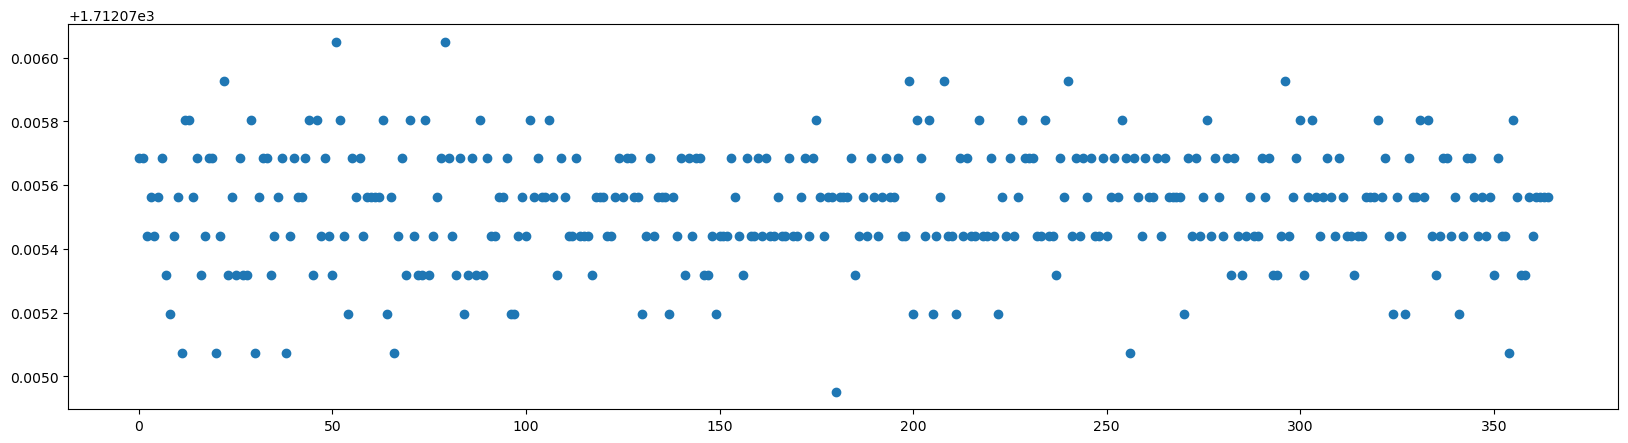

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(num_days), gamma_document.sum(axis=0))

In [30]:
## entropy of dirichlet distribution
entropy = torch.distributions.dirichlet.Dirichlet(theta_dict['params']['alpha'].detach()).entropy()

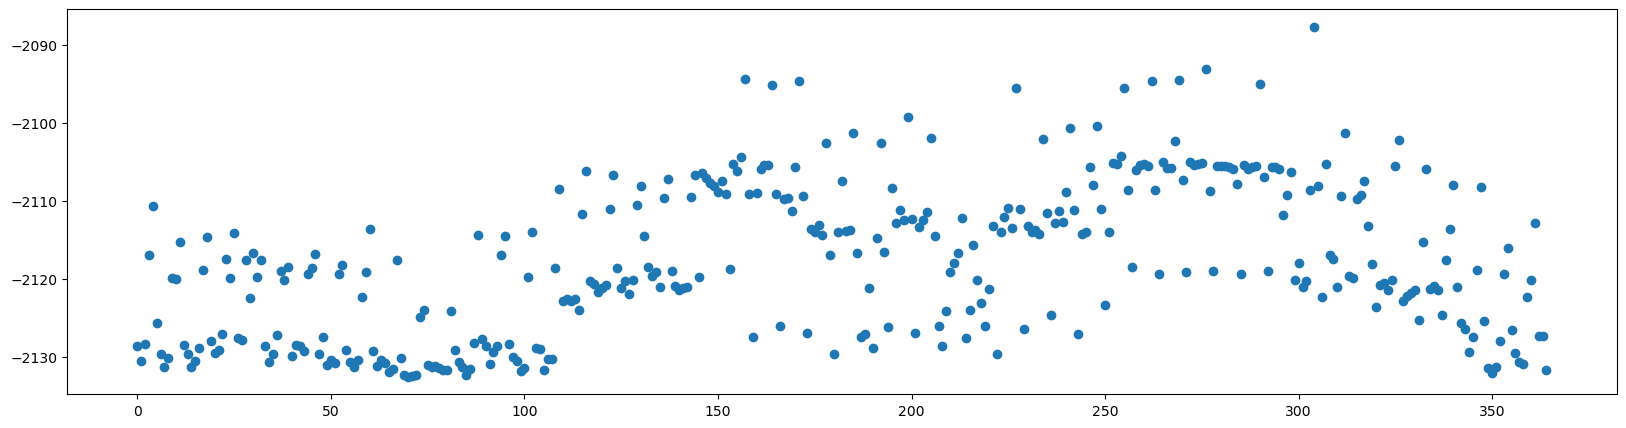

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(num_days), entropy)

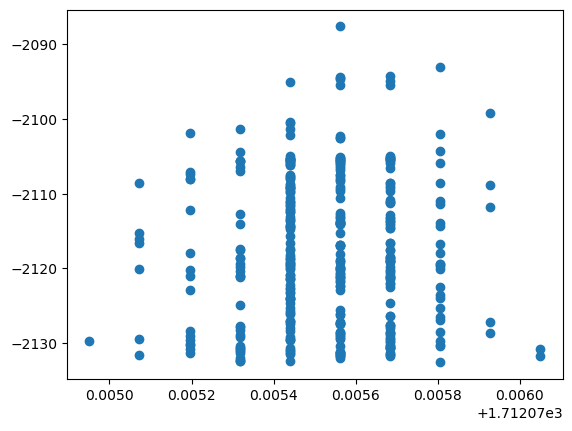

In [32]:
plt.scatter(gamma_document.sum(axis=0), entropy)

In [33]:
corpus = X_document.to(torch.float32)
# corp_counts = corpus.sum(dim=1, keepdim=True)
inputs = corpus

In [34]:
# zeta = model.encoder(inputs)["alpha"].log().sigmoid().detach()
zeta = model.encoder(inputs)["alpha"].log().softmax(-1).detach()

In [35]:
Beta = model.decoder.beta_unnorm.detach().softmax(dim=-1)

In [36]:
phi = Beta*zeta.unsqueeze(-1)
phi /= phi.sum(dim=1,keepdim=True)

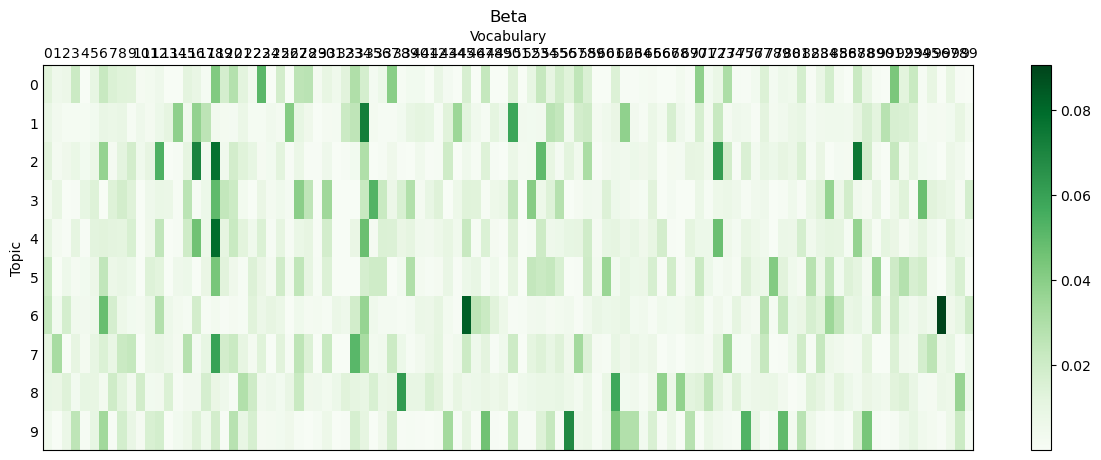

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(Beta, aspect='auto', cmap='Greens', interpolation='none')
ax.set_title(f'Beta')
ax.set_ylabel('Topic')
ax.set_xlabel('Vocabulary')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(dict_size))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax)
plt.show()

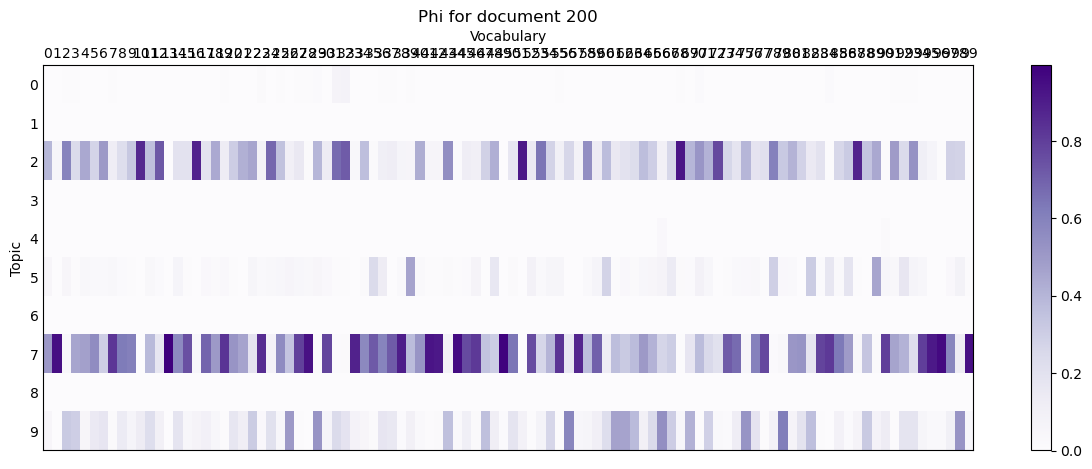

In [38]:
doc_no = 200
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(phi[doc_no], aspect='auto', cmap='Purples', interpolation='none')
ax.set_title(f'Phi for document {doc_no}')
ax.set_ylabel('Topic')
ax.set_xlabel('Vocabulary')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(dict_size))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax)
plt.show()

In [39]:
zeta[doc_no]

tensor([2.4535e-03, 1.1563e-11, 3.4024e-01, 2.4718e-06, 2.4737e-04, 2.5693e-02,
        1.3649e-11, 4.9981e-01, 1.0620e-11, 1.3155e-01])

In [40]:
gamma_document_mean[:,doc_no]

tensor([2.7050e-03, 7.6510e-07, 3.2530e-01, 4.4029e-05, 3.3815e-04, 2.8211e-02,
        7.8241e-07, 5.1432e-01, 1.0425e-06, 1.2907e-01])

In [41]:
zeta[doc_no]*num_users+model.prior_params["alpha"].exp()

tensor([4.6553e+00, 1.3099e-03, 5.8270e+02, 7.5064e-02, 5.7803e-01, 4.4685e+01,
        1.3395e-03, 8.5447e+02, 1.7849e-03, 2.2491e+02],
       grad_fn=<AddBackward0>)

In [42]:
gamma_document[:,doc_no]

tensor([4.6312e+00, 1.3099e-03, 5.5695e+02, 7.5380e-02, 5.7894e-01, 4.8300e+01,
        1.3395e-03, 8.8056e+02, 1.7849e-03, 2.2098e+02])

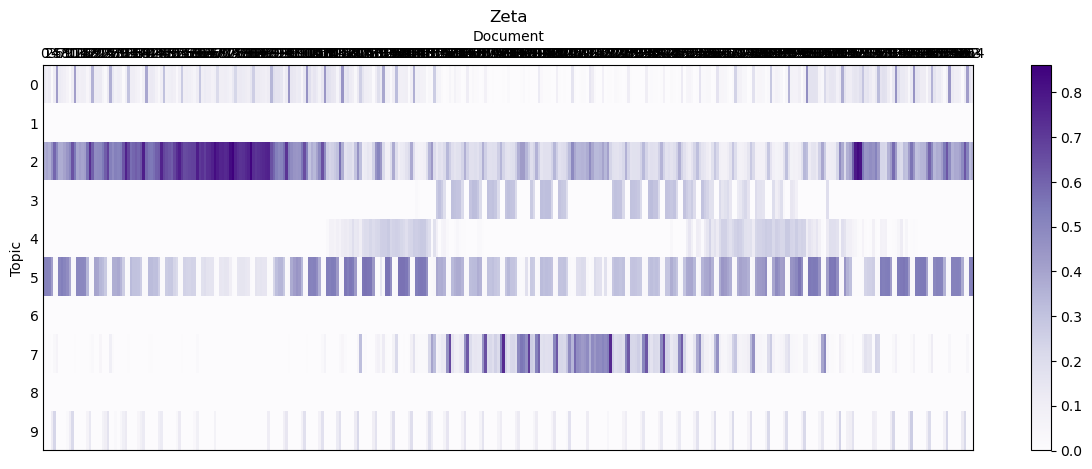

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(zeta.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Zeta')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax)
plt.show()

In [44]:
missing_document = X_document[0]
missing_document = missing_document/missing_document.sum()*(num_users*0.01)
missing_document = missing_document.round().to(torch.float32)
num_words = missing_document.sum().item()
print(f"Number of words in the missing document: {num_words}")

Number of words in the missing document: 4.0


In [45]:
_, theta_missing = model(missing_document.unsqueeze(0))
gamma_missing = theta_missing['params']['alpha'].detach().T
gamma_missing_mean = gamma_missing / gamma_missing.sum(dim=0, keepdim=True)

/tmp/ipykernel_24658/1250773554.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  gamma_missing = theta_missing['params']['alpha'].detach().T


In [46]:
gamma_missing

tensor([6.6177e-01, 1.3099e-03, 4.4439e+00, 7.0839e-02, 1.5529e-01, 1.3636e+00,
        1.3395e-03, 2.9013e-01, 1.7849e-03, 8.5634e-02])

In [47]:
gamma_document[:,0]

tensor([2.0658e+02, 1.3099e-03, 6.2383e+02, 7.0841e-02, 1.6173e-01, 8.7372e+02,
        1.3395e-03, 7.6251e+00, 1.7849e-03, 8.5661e-02])

In [48]:
zeta = model.encoder(missing_document)["alpha"].log().softmax(-1).detach()

In [49]:
zeta

tensor([[8.2671e-02, 7.6124e-22, 6.9443e-01, 6.8510e-13, 5.1266e-14, 2.2289e-01,
         7.2520e-22, 4.0095e-07, 5.2594e-23, 8.5549e-17]])

In [50]:
zeta*num_words+model.prior_params["alpha"].exp()

tensor([[7.9298e-01, 1.3099e-03, 4.0099e+00, 7.0839e-02, 1.5529e-01, 1.6663e+00,
         1.3395e-03, 2.9013e-01, 1.7849e-03, 8.5634e-02]],
       grad_fn=<AddBackward0>)

In [51]:
gamma_missing_mean

tensor([9.3530e-02, 1.8513e-04, 6.2806e-01, 1.0012e-02, 2.1947e-02, 1.9272e-01,
        1.8932e-04, 4.1005e-02, 2.5226e-04, 1.2103e-02])

In [52]:
phi = Beta*zeta.unsqueeze(-1)
phi /= phi.sum(dim=1,keepdim=True)

In [53]:
phi

tensor([[[7.4136e-02, 1.9038e-01, 1.0629e-01, 2.2943e-01, 2.2890e-03,
          1.1135e-01, 5.5569e-02, 3.0467e-01, 1.0170e-01, 6.9620e-02,
          4.5134e-02, 2.3368e-02, 1.1488e-02, 1.3064e-02, 1.2773e-02,
          9.6576e-02, 1.4109e-02, 2.5303e-02, 5.1528e-02, 1.9999e-01,
          1.4294e-01, 9.4350e-02, 2.9488e-02, 5.7625e-01, 7.7190e-03,
          1.0831e-01, 2.1515e-03, 1.6673e-01, 4.6663e-01, 2.9273e-01,
          9.7791e-02, 6.0750e-01, 6.2596e-01, 5.1789e-01, 5.6316e-02,
          4.1344e-02, 9.2862e-02, 4.8356e-01, 7.0123e-02, 3.8947e-02,
          7.4769e-02, 3.2745e-03, 3.8756e-01, 1.2984e-02, 5.7983e-02,
          2.2366e-01, 1.7979e-03, 1.5987e-01, 1.1291e-03, 1.5944e-01,
          1.2853e-01, 6.0484e-03, 9.9718e-02, 4.5802e-02, 6.6818e-02,
          2.3067e-01, 1.1826e-01, 3.9028e-01, 4.6582e-02, 2.4313e-02,
          2.0092e-03, 2.0637e-01, 7.7233e-03, 5.0318e-03, 2.4376e-02,
          1.6748e-02, 7.4322e-02, 4.5513e-03, 1.1692e-01, 5.3285e-03,
          2.1999e-01